In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


# Neural Net Model

## low layer

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class GPN(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_class):
        super(GPN, self).__init__()
        self.size = 0
        self.batch_size = 0
        self.dim = n_hidden
        
        v  = torch.FloatTensor(n_hidden).cuda()
        h0 = torch.FloatTensor(n_hidden).cuda()
        c0 = torch.FloatTensor(n_hidden).cuda()
        r1 = torch.ones(1).cuda()
        r2 = torch.ones(1).cuda()
        r3 = torch.ones(1).cuda()
        gamma = torch.ones(1).cuda()
        self.v  = nn.Parameter(v)
        self.h0 = nn.Parameter(h0)
        self.c0 = nn.Parameter(c0)
        self.r1  = nn.Parameter(r1)
        self.r2  = nn.Parameter(r2)
        self.r3  = nn.Parameter(r3)
        self.gamma = nn.Parameter(gamma)
        self.v.data.uniform_(-1/math.sqrt(n_hidden), 1/math.sqrt(n_hidden))
        self.h0.data.uniform_(-1/math.sqrt(n_hidden), 1/math.sqrt(n_hidden))
        self.c0.data.uniform_(-1/math.sqrt(n_hidden), 1/math.sqrt(n_hidden))
        
        # embedding
        self.embedding_x = nn.Linear(n_feature, n_hidden)
        self.embedding_all = nn.Linear(n_feature, n_hidden)
        # self.encoder_ori = GCNConv(n_hidden, n_hidden)    # use GCN as encoder
        self.encoder_1 = nn.Linear(n_hidden, n_hidden)    # use GCN as encoder
        self.encoder_2 = nn.Linear(n_hidden, n_hidden)    # use GCN as encoder        
        self.encoder_3 = nn.Linear(n_hidden, n_hidden)    # use GCN as encoder
        
        self.enc_1 = nn.Linear(n_hidden, n_hidden)    # use GCN as encoder
        self.enc_2 = nn.Linear(n_hidden, n_hidden)    # use GCN as encoder        
        self.enc_3 = nn.Linear(n_hidden, n_hidden)    # use GCN as encoder
                
        # parameters for input gate
        self.Wxi = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Whi = nn.Linear(n_hidden, n_hidden)    # W(ht)
        self.wci = nn.Linear(n_hidden, n_hidden)    # w(ct)
        
        # parameters for forget gate
        self.Wxf = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Whf = nn.Linear(n_hidden, n_hidden)    # W(ht)
        self.wcf = nn.Linear(n_hidden, n_hidden)    # w(ct)
        
        # parameters for cell gate
        self.Wxc = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Whc = nn.Linear(n_hidden, n_hidden)    # W(ht)
        
        # parameters for forget gate
        self.Wxo = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Who = nn.Linear(n_hidden, n_hidden)    # W(ht)
        self.wco = nn.Linear(n_hidden, n_hidden)    # w(ct)
        
        # parameters for pointer attention
        self.Wref = nn.Linear(n_hidden, n_hidden)
        self.Wq = nn.Linear(n_hidden, n_hidden)
        
        
    def forward(self, x, input, mask, h=None, c=None):
        ''' args
        x: current city (B, 2)
        input: all cities (B*size, 2)
        h: hidden variable (B, dim)
        c: cell gate (B, dim)
        context: encoded context, encoder(input) --> (B*size, dim)
        '''
        self.batch_size = x.size(0)
        self.size = int(input.size(0) / self.batch_size)
        
        if h is None:
            h = self.h0.unsqueeze(0).expand(self.batch_size, self.dim)
        if c is None:
            c = self.c0.unsqueeze(0).expand(self.batch_size, self.dim)


        x = self.embedding_x(x)
        context = self.embedding_all(input)
        
        context = self.enc_1(context) + F.relu(self.encoder_1(context))
        # context = self.enc_2(context) + F.relu(self.encoder_2(context))
        # context = self.enc_3(context) + F.relu(self.encoder_3(context))
                
        # hidden variable does not have graph structure
        # input gate
        i = torch.sigmoid(self.Wxi(x) + self.Whi(h) + self.wci(c))
        # forget gate
        f = torch.sigmoid(self.Wxf(x) + self.Whf(h) + self.wcf(c))
        # cell gate
        c = f*c + i*torch.tanh(self.Wxc(x) + self.Whc(h))
        # output gate
        o = torch.sigmoid(self.Wxo(x) + self.Who(h) + self.wco(c))
        h = o*torch.tanh(c)
        

        # query and reference
        q = h
        ref = context
        q = self.Wq(q)     # (B, dim)
        ref = self.Wref(ref)
        ref = ref.view(self.batch_size, self.size, self.dim)  # (B, size, dim)
        
        q_ex = q.unsqueeze(1).repeat(1, self.size, 1) # (B, size, dim)
        # v_view: (B, dim, 1)
        v_view = self.v.unsqueeze(0).expand(self.batch_size, self.dim).unsqueeze(2)
        
        # (B, size, dim) * (B, dim, 1)
        u = torch.bmm(torch.tanh(q_ex + ref), v_view).squeeze(2)
        hidden_u = u.clone()
        u = 10*torch.tanh(u) + mask
        return F.softmax(u, dim=1), h, c, hidden_u

## high layer

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class GPN_High(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_class):
        super(GPN_High, self).__init__()
        self.size = 0
        self.batch_size = 0
        self.dim = n_hidden
        
        v  = torch.FloatTensor(n_hidden).cuda()
        h0 = torch.FloatTensor(n_hidden).cuda()
        c0 = torch.FloatTensor(n_hidden).cuda()
        r1 = torch.ones(1).cuda()
        r2 = torch.ones(1).cuda()
        r3 = torch.ones(1).cuda()
        gamma = torch.ones(1).cuda()
        self.v  = nn.Parameter(v)
        self.h0 = nn.Parameter(h0)
        self.c0 = nn.Parameter(c0)
        self.r1  = nn.Parameter(r1)
        self.r2  = nn.Parameter(r2)
        self.r3  = nn.Parameter(r3)
        self.gamma = nn.Parameter(gamma)
        self.v.data.uniform_(-1/math.sqrt(n_hidden), 1/math.sqrt(n_hidden))
        self.h0.data.uniform_(-1/math.sqrt(n_hidden), 1/math.sqrt(n_hidden))
        self.c0.data.uniform_(-1/math.sqrt(n_hidden), 1/math.sqrt(n_hidden))
        
        # embedding
        self.embedding_x = nn.Linear(n_feature, n_hidden)
        self.embedding_all = nn.Linear(n_feature, n_hidden)
        # self.encoder_ori = GCNConv(n_hidden, n_hidden)    # use GCN as encoder
        self.encoder_1 = nn.Linear(n_hidden, n_hidden)    # use GCN as encoder
        self.encoder_2 = nn.Linear(n_hidden, n_hidden)    # use GCN as encoder        
        self.encoder_3 = nn.Linear(n_hidden, n_hidden)    # use GCN as encoder
        
        self.enc_1 = nn.Linear(n_hidden, n_hidden)    # use GCN as encoder
        self.enc_2 = nn.Linear(n_hidden, n_hidden)    # use GCN as encoder        
        self.enc_3 = nn.Linear(n_hidden, n_hidden)    # use GCN as encoder
                
        # parameters for input gate
        self.Wxi = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Whi = nn.Linear(n_hidden, n_hidden)    # W(ht)
        self.wci = nn.Linear(n_hidden, n_hidden)    # w(ct)
        
        # parameters for forget gate
        self.Wxf = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Whf = nn.Linear(n_hidden, n_hidden)    # W(ht)
        self.wcf = nn.Linear(n_hidden, n_hidden)    # w(ct)
        
        # parameters for cell gate
        self.Wxc = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Whc = nn.Linear(n_hidden, n_hidden)    # W(ht)
        
        # parameters for forget gate
        self.Wxo = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Who = nn.Linear(n_hidden, n_hidden)    # W(ht)
        self.wco = nn.Linear(n_hidden, n_hidden)    # w(ct)
        
        # parameters for pointer attention
        self.Wref = nn.Linear(n_hidden, n_hidden)
        self.Wq = nn.Linear(n_hidden, n_hidden)
        
        
    def forward(self, x, input, mask, latent, h=None, c=None):
        ''' args
        x: current city (B, 2)
        input: all cities (B*size, 2)
        h: hidden variable (B, dim)
        c: cell gate (B, dim)
        context: encoded context, encoder(input) --> (B*size, dim)
        '''
        self.batch_size = x.size(0)
        self.size = int(input.size(0) / self.batch_size)
        # print(self.size)
        
        if h is None:
            h = self.h0.unsqueeze(0).expand(self.batch_size, self.dim)
        if c is None:
            c = self.c0.unsqueeze(0).expand(self.batch_size, self.dim)


        x = self.embedding_x(x)
        context = self.embedding_all(input)
        
        context = self.enc_1(context) + F.relu(self.encoder_1(context))
        # context = self.enc_2(context) + F.relu(self.encoder_2(context))
        # context = self.enc_3(context) + F.relu(self.encoder_3(context))
                
        # hidden variable does not have graph structure
        # input gate
        i = torch.sigmoid(self.Wxi(x) + self.Whi(h) + self.wci(c))
        # forget gate
        f = torch.sigmoid(self.Wxf(x) + self.Whf(h) + self.wcf(c))
        # cell gate
        c = f*c + i*torch.tanh(self.Wxc(x) + self.Whc(h))
        # output gate
        o = torch.sigmoid(self.Wxo(x) + self.Who(h) + self.wco(c))
        h = o*torch.tanh(c)
        

        # query and reference
        q = h
        ref = context
        q = self.Wq(q)     # (B, dim)
        ref = self.Wref(ref)
        ref = ref.view(self.batch_size, self.size, self.dim)  # (B, size, dim)
        
        q_ex = q.unsqueeze(1).repeat(1, self.size, 1) # (B, size, dim)
        # v_view: (B, dim, 1)
        v_view = self.v.unsqueeze(0).expand(self.batch_size, self.dim).unsqueeze(2)
        
        # (B, size, dim) * (B, dim, 1)
        u = torch.bmm(torch.tanh(q_ex + ref), v_view).squeeze(2)
        u = 10*torch.tanh(u) + mask + self.gamma * latent
        return F.softmax(u, dim=1), h, c

# Training

In [0]:
import numpy as np

import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
from scipy.spatial.distance import squareform, pdist
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [0]:
model_low = torch.load('drive/My Drive/GCN-CO/model/0420/TSP50.pt')

In [0]:
size = 50

learn_rate = 1e-3
beta = 0.8
B = 128

In [0]:
model_high = GPN_High(n_feature=3,
            n_hidden=128,
            n_class=1)

In [0]:
model_high.cuda()
model_low.cuda()

learn_rate = 1e-3
lr_decay_step = 5000
lr_decay_rate = 0.96


optimizer = optim.Adam(model_high.parameters(), lr=learn_rate)

opt_scheduler = lr_scheduler.MultiStepLR(optimizer, range(lr_decay_step, lr_decay_step*1000,
                                         lr_decay_step), gamma=lr_decay_rate)

# TSPTW

In [0]:
X = np.random.rand(B*size, 2)
Time = 5*np.random.rand(B*size,1)
print(X.shape,Time.shape)
Z = np.concatenate((X, Time), axis=1)
print(Z.shape)

(6400, 2) (6400, 1)
(6400, 3)


In [0]:
# consider time information

B = 128    # batch_size
C = 0     # baseline
R = 0     # reward

model_low.eval()
model_high.train()

reward = 0
for i in range(5000):
    optimizer.zero_grad()

    X = np.random.rand(B*size, 2)
    Time = 5*np.random.rand(B*size,1)
    Time = Time.reshape(B,size,1)
    Time[:,0] = 0
    Time = Time.reshape(B*size,1)

    X = np.concatenate((X, Time), axis=1)
    
    X = torch.Tensor(X).cuda()
    Time = torch.Tensor(Time).cuda()
    mask = torch.zeros(B,size).cuda()

    reward = 0
    R = torch.zeros(B).cuda()
    logprobs = 0
    time_cost = torch.zeros(B).cuda()
    total_time_cost = torch.zeros(B).cuda()
    T = torch.zeros(B).cuda()
   
    
    Y = X.view(B,size,3)           # to the same batch size
    Time = Time.view(B,size)
    x = Y[:,0,:]
    h = None
    c = None

    # print(Y.size())
    
    for k in range(size):
        
        output, h, c, hidden_u = model_low(x=x[:,:2], input=X[:,:2], h=h, c=c, mask=mask)
        # hidden_u = 0
        output, h, c = model_high(x=x, input=X, h=h, c=c, mask=mask, latent=hidden_u)
        
        sampler = torch.distributions.Categorical(output)
        # idx = torch.argmax(output, dim=1)
        idx = sampler.sample()         # now the idx has B elements

        # print(output)
        
        Y1 = Y[[i for i in range(B)], idx.data]

        
        if k == 0:
            Y_ini = Y1.clone()
        if k > 0:
            reward = torch.norm(Y1[:,:2]-Y0[:,:2], dim=1)

        # print("test")
        Y0 = Y1.clone()
        x = Y[[i for i in range(B)], idx.data]
        
        R += reward
        total_time_cost += reward
        
        # enter time
        time = Time[[i for i in range(B)], idx.data]
        # determine the total reward and current enter time
        time_cost = torch.lt(total_time_cost, time).float()*(time - total_time_cost)  
        
        total_time_cost += time_cost
        T += time_cost     # total time cost

        TINY = 1e-15
        logprobs += torch.log(output[[i for i in range(B)], idx.data]+TINY) 
        
        mask[[i for i in range(B)], idx.data] += -np.inf 
       

    R += torch.norm(Y1[:,:2]-Y_ini[:,:2], dim=1)
    
    if i == 0:
        C = total_time_cost.mean()
    else:
        C = (total_time_cost * beta) + ((1. - beta) * total_time_cost.mean())
    
    loss = ((total_time_cost-C)*logprobs).mean()

    loss.backward()
    
    max_grad_norm = 1.0
    torch.nn.utils.clip_grad_norm_(model_low.parameters(),
                                       max_grad_norm, norm_type=2)
    optimizer.step()
    opt_scheduler.step()
    
    if i % 50 == 0:
        print("epoch:{}, loss:{}, reward:{}, time:{}"
            .format(i,loss.item(),R.mean().item(), T.mean().item()))

epoch:0, loss:-0.5635337829589844, reward:9.112625122070312, time:0.6236771941184998
epoch:50, loss:-0.03489159047603607, reward:8.654573440551758, time:1.0510509014129639
epoch:100, loss:-0.12127609550952911, reward:8.743059158325195, time:0.8178374767303467
epoch:150, loss:-0.04674021154642105, reward:8.853475570678711, time:0.733428955078125
epoch:200, loss:-0.10001125931739807, reward:9.05912971496582, time:0.5542683005332947
epoch:250, loss:-0.042808376252651215, reward:9.033817291259766, time:0.6222018003463745
epoch:300, loss:-0.04344319552183151, reward:8.961321830749512, time:0.8123394250869751
epoch:350, loss:-0.1761457920074463, reward:8.967403411865234, time:0.7493728399276733
epoch:400, loss:-0.0811735987663269, reward:8.890156745910645, time:0.7346435785293579
epoch:450, loss:-0.0596654936671257, reward:8.875138282775879, time:0.6490026116371155
epoch:500, loss:-0.11659561097621918, reward:9.208836555480957, time:0.5808483362197876
epoch:550, loss:-0.0928509309887886, rew

# Inference

In [0]:
B = 1
size = 50

X = np.random.rand(B*size, 2)
Time = 5*np.random.rand(B*size,1)
Time = Time.reshape(B,size,1)
Time[:,0] = 0
Time = Time.reshape(B*size,1)
X = np.concatenate((X,Time), axis=1)

time_cost = 0
total_time_cost = torch.zeros(B).cuda()
X = torch.Tensor(X).cuda()
Time = torch.Tensor(Time).cuda()
mask = torch.zeros(B,size).cuda()
 
R = torch.zeros(B).cuda()
logprobs = 0
reward = 0

solution = []
T = 0
Y = X.view(B,size,3)           # to the same batch size
Y_Time = Time
Time = Time.view(B,size)
x = Y[:,0,:]
h = None
c = None
divide = 0


enter_time = []
pass_time = []

# print(Y.size())

for k in range(size):
    
    output, h, c, hidden_u = model_low(x=x[:,:2], input=X[:,:2], h=h, c=c, mask=mask)
    output, h, c = model_high(x=x, input=X, h=h, c=c, mask=mask, latent=hidden_u)
    
    sampler = torch.distributions.Categorical(output)
    # idx = sampler.sample()         # now the idx has B elements
    idx = torch.argmax(output, dim=1)

    Y1 = Y[[i for i in range(B)], idx.data]
    
    if k == 0:
        Y_ini = Y1.clone()
    if k > 0:
        reward = torch.norm(Y1[:,:2]-Y0[:,:2], dim=1)

    Y0 = Y1.clone()
    x = Y[[i for i in range(B)], idx.data]

    solution.append(x[0,:2].cpu().numpy())
    
    R += reward
    total_time_cost += reward
    
    # enter time
    time = Time[[i for i in range(B)], idx.data]

    # determine the total reward and current enter time
    time_cost = torch.lt(total_time_cost, time).float()*(time - total_time_cost)  
    
    if time_cost.item()>0:
        divide = k
    
    total_time_cost += time_cost
    T += time_cost     # total time cost

    
    mask[[i for i in range(B)], idx.data] += -np.inf 
    
    print("time:{}, distance:{}".format(time.item(), total_time_cost.item()))
    enter_time.append(time.item())
    pass_time.append(total_time_cost.item())
    
    
R += torch.norm(Y1[:,:2]-Y_ini[:,:2], dim=1)
total_time_cost += torch.norm(Y1[:,:2]-Y_ini[:,:2], dim=1)


print("total length:", total_time_cost.item())
print("time cost:", T.item())
print("tour lenght:", R.item())

time:0.0, distance:0.0
time:0.295327365398407, distance:0.33913496136665344
time:0.9984871745109558, distance:0.9984871745109558
time:0.763039231300354, distance:1.266855001449585
time:1.268875002861023, distance:1.6089143753051758
time:1.353973150253296, distance:1.8912614583969116
time:0.6640166640281677, distance:1.9896411895751953
time:2.023508310317993, distance:2.313350200653076
time:0.36442306637763977, distance:2.387784481048584
time:0.6906937956809998, distance:2.5786213874816895
time:1.539695382118225, distance:2.708146810531616
time:1.0814710855484009, distance:2.90852952003479
time:2.9543755054473877, distance:2.9543755054473877
time:0.6871660351753235, distance:3.2436091899871826
time:3.2388479709625244, distance:3.348568916320801
time:1.2242628335952759, distance:3.43845534324646
time:2.0252959728240967, distance:3.499624729156494
time:0.47900083661079407, distance:3.6414108276367188
time:4.094509601593018, distance:4.094509601593018
time:3.3222713470458984, distance:4.30

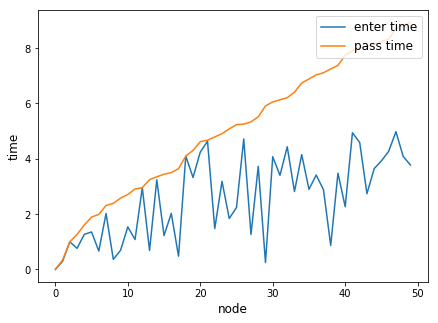

In [0]:
plt.figure(figsize=(7,5))
t = range(50)
plt.plot(t, enter_time, label='enter time')
plt.plot(t, pass_time, label='pass time')

plt.xlabel('node', fontsize=12)
plt.ylabel('time', fontsize=12)
plt.legend(loc='upper right', fontsize=12)

In [0]:
solution.append(solution[0])
route = np.array(solution)

In [0]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'cost: 9.175')

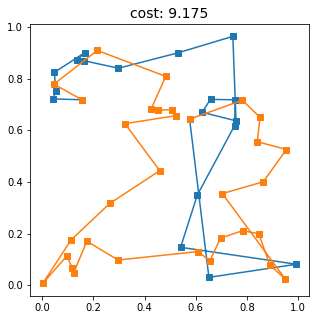

In [0]:
plt.figure(figsize=(5,5))
plt.plot(route[:divide,0],route[:divide,1], marker='s')
plt.plot(route[divide-1:,0],route[divide-1:,1], marker='s')
plt.title('cost: 9.175', fontsize=14)

# Test

## random test

In [0]:
B = 1000
size = 50

X = np.random.rand(B*size, 2)
Time = 5*np.random.rand(B*size,1)
Time = Time.reshape(B,size,1)
Time[:,0] = 0
Time = Time.reshape(B*size,1)
X = np.concatenate((X,Time), axis=1)


X = torch.Tensor(X).cuda()
Time = torch.Tensor(Time).cuda()
mask = torch.zeros(B,size).cuda()
 
    
time_cost = 0
total_time_cost = torch.zeros(B).cuda()
T = torch.zeros(B).cuda()
R = torch.zeros(B).cuda()
reward = 0

Y = X.view(B,size,3)           # to the same batch size
Y_Time = Time
Time = Time.view(B,size)
x = Y[:,0,:]
h = None
c = None

# print(Y.size())

for k in range(size):
    
    output, h, c = model_high(x=x, input=X, h=h, c=c, mask=mask, latent=0)
    
    sampler = torch.distributions.Categorical(output)
    # idx = sampler.sample()         # now the idx has B elements
    idx = torch.argmax(output, dim=1)

    Y1 = Y[[i for i in range(B)], idx.data]
    
    if k == 0:
        Y_ini = Y1.clone()
    if k > 0:
        reward = torch.norm(Y1[:,:2]-Y0[:,:2], dim=1)

    Y0 = Y1.clone()
    x = Y[[i for i in range(B)], idx.data]
    
    R += reward
    total_time_cost += reward
    
    # enter time
    time = Time[[i for i in range(B)], idx.data]

    # determine the total reward and current enter time
    time_cost = torch.lt(total_time_cost, time).float()*(time - total_time_cost)  

    
    total_time_cost += time_cost
    T += time_cost     # total time cost

    
    mask[[i for i in range(B)], idx.data] += -np.inf 

    
R += torch.norm(Y1[:,:2]-Y_ini[:,:2], dim=1)
total_time_cost += torch.norm(Y1[:,:2]-Y_ini[:,:2], dim=1)


print("total time cost:", total_time_cost.mean().item())
print("time cost:", T.mean().item())
print("tour lenght:", R.mean().item())

## held-out data test

In [0]:
from tqdm import tqdm
import torch
from torch.utils.data import Dataset
import numpy as np
import time as tm
from scipy.spatial import distance

In [0]:
# Training Data
class TSPDataset(Dataset):
    
    def __init__(self, dataset_fname=None, train=False, size=50, num_samples=100000, random_seed=1111):
        super(TSPDataset, self).__init__()
        
        torch.manual_seed(random_seed)

        self.data_set = {"x":[], "time":[]}
        
        # randomly sample points uniformly from [0, 1]
        for l in tqdm(range(num_samples)):
            x = torch.FloatTensor(2, size).uniform_(0, 1)
#             time = torch.cat((torch.FloatTensor(1, size).uniform_(0, 5), 1000 * torch.ones(1, size)), 0)
            time = torch.cat((torch.FloatTensor(1, size).uniform_(0, 5), torch.FloatTensor(1, size).uniform_(1000, 1300)), 0)
            time[0][0] = 0
            
            #x = torch.cat([start, x], 1)
            self.data_set["x"].append(x)
            self.data_set["time"].append(time)

        self.size = len(self.data_set)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):

        return self.data_set["x"][idx], self.data_set["time"][idx]

In [0]:
dataset = torch.load('drive/My Drive/GCN-CO/TSPTW50_in_U05_1000.pt')

In [0]:
B = 1000
size = 50

X = torch.zeros(B, size, 3)
Time = torch.zeros(B, size)
for i in range(B):
    X[i, :,:2] = dataset[i][0].transpose(1,0)
    X[i, :,2:] = dataset[i][1].transpose(1,0)[:,0:1]
    Time[i, :] = dataset[i][1].transpose(1,0)[:,0]

X = X.view(B*size,3).cuda()
Time = Time.view(B*size).cuda()
mask = torch.zeros(B,size).cuda()
 
    
time_cost = 0
total_time_cost = torch.zeros(B).cuda()
T = torch.zeros(B).cuda()
R = torch.zeros(B).cuda()
reward = 0

Y = X.view(B,size,3)           # to the same batch size
Y_Time = Time
Time = Time.view(B,size)
x = Y[:,0,:]
h = None
c = None

# print(Y.size())

for k in range(size):
    
    output, h, c = model_high(x=x, input=X, h=h, c=c, mask=mask, latent=0)
    
    sampler = torch.distributions.Categorical(output)
    # idx = sampler.sample()         # now the idx has B elements
    idx = torch.argmax(output, dim=1)

    Y1 = Y[[i for i in range(B)], idx.data]
    
    if k == 0:
        Y_ini = Y1.clone()
    if k > 0:
        reward = torch.norm(Y1[:,:2]-Y0[:,:2], dim=1)

    Y0 = Y1.clone()
    x = Y[[i for i in range(B)], idx.data]
    
    R += reward
    total_time_cost += reward
    
    # enter time
    time = Time[[i for i in range(B)], idx.data]

    # determine the total reward and current enter time
    time_cost = torch.lt(total_time_cost, time).float()*(time - total_time_cost)  

    
    total_time_cost += time_cost
    T += time_cost     # total time cost

    
    mask[[i for i in range(B)], idx.data] += -np.inf 

    
R += torch.norm(Y1[:,:2]-Y_ini[:,:2], dim=1)
total_time_cost += torch.norm(Y1[:,:2]-Y_ini[:,:2], dim=1)


print("total time cost:", total_time_cost.mean().item())
print("time cost:", T.mean().item())
print("tour lenght:", R.mean().item())

total time cost: 9.619950294494629
time cost: 0.9608845710754395
tour lenght: 8.659066200256348
